In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

import numpy as np

#### this function builds a Quantum Fourier Transform* gate

*it's a modified version without swaps

In [39]:
def QuantumFourierTransform(digits: int):
    
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegY)

    for i, q in enumerate(QRegY):
        QC.h(q)

        theta = np.pi / 2
        for r in QRegY[i + 1:]:
            QC.cp(theta, r, q)
            theta /= 2
    
    return QC.to_gate()

#### the following function builds a oracle, $U_C$, such that $U_C | x \rangle | y \rangle = | x \rangle | y - C (x) \rangle$

todo: we can probably save some circuit by removing the swap-gates in QFT and reshuffling gates here

In [40]:
def EnergyOracle(GraphLaplacian: list[list[int]], digits: int):

    QRegX = QuantumRegister(len(GraphLaplacian))
    QRegY = QuantumRegister(digits)
    
    QC = QuantumCircuit(QRegX, QRegY)

    QFT = QuantumFourierTransform(digits)
    QC.append(QFT, QRegY)
    
    # Phasers
    for i, v in enumerate(GraphLaplacian):
        theta = - np.pi * v[i]
        # QRegY is reversed below to save on swaps in QFT
        for q in reversed(QRegY):
            QC.cp(theta, QRegX[i], q)
            theta /= 2

        for j, w in enumerate(GraphLaplacian[i][i + 1:]):
            if w != 0:
                theta = - 2 * np.pi * w
                # QRegY is reversed below to save on swaps in QFT
                for q in reversed(QRegY):
                    QC.mcp(theta, [QRegX[i], QRegX[i + 1 + j]], q)
                    theta /= 2

    QC.append(QFT.inverse(), QRegY)

    return QC.to_gate()

#### the following creates the Grover fixed point circuit, $S_L = G \left( \alpha_l, \beta_l \right) \cdots G \left( \alpha_1, \beta_1 \right) H^{\otimes n}$

In [41]:
def GroverFixedPointGate(GraphLaplacian: list[list[int]], digits: int, l: int, delta: float):

    L = 2*l + 1
    gamma = np.sqrt(1 - 1 / pow(np.cosh(np.arccosh(1/delta) / L), 2))

    alpha = [2 * np.arctan(1 / (gamma * np.tan(2 * np.pi * j / L))) for j in range(1, l + 1)]
    
    U_C = EnergyOracle(GraphLaplacian, digits)
    U_C_inverse = U_C.inverse()

    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY)

    QC.h(QRegX)

    for _, (a, b) in enumerate(zip(alpha, reversed(alpha))):

        # S_t (beta)
        QC.append(U_C, QRegX[:] + QRegY[:])
        QC.p(- b, QRegY[0])
        QC.append(U_C_inverse, QRegX[:] + QRegY[:])
        
        # S_s (alpha)
        QC.h(QRegX)
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(a, QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.h(QRegX)

    return QC.to_gate()

#### the following builds the circuit for the new QAOA

In [42]:
def GroverQAOACircuit(GraphLaplacian: list[list[int]], digits: int, y: int, delta: float, l: int, bangs: list[list[int]], NumberOfShots: int):

    # one quantum/classical register pair for each vertex
    QRegX = QuantumRegister(len(GraphLaplacian), "x")
    ClRegX = ClassicalRegister(len(GraphLaplacian), "cl-x")

    # quantum registers to digitize y
    QRegY = QuantumRegister(digits, "y")

    QC = QuantumCircuit(QRegX, QRegY, ClRegX)

    GroverMixer = GroverFixedPointGate(GraphLaplacian, digits, l, delta)
    GroverMixer.label = "GroverMixer"
    InverseGroverMixer = GroverMixer.inverse()
    InverseGroverMixer.label = "GroverMixerInverse"

    for q in QRegX:
        QC.initialize([1, 0], q)

    for i, q in enumerate(QRegY):
        # y - 1 is used, so states with f(x) >= y are flagged
        QC.initialize([1 - ((y-1) >> (digits - i - 1))%2, ((y-1) >> (digits - i - 1))%2], q)

    QC.append(GroverMixer, QRegX[:] + QRegY[:])

    # the bangs / p = len(bangs) / going backward per convention
    for bang in reversed(bangs):

        # this implements the phase-bang
        for i, q in enumerate(QRegY):
            QC.p(bang[1] *(1 << (digits - i - 1)), q)

        # this is the Grover-bang
        QC.append(InverseGroverMixer, QRegX[:] + QRegY[:])
        QC.x(QRegX)
        # can we improve on mcp???
        QC.mcp(bang[0], QRegX[:-1], QRegX[-1])
        QC.x(QRegX)
        QC.append(GroverMixer, QRegX[:] + QRegY[:])

    QC.measure(QRegX, ClRegX)
    
    #display(QC.draw(output='mpl'))
    
    # error probabilities
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.05

    # QuantumError objects (???)
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)
    
    # errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    # simulation
    noisy_simulator = AerSimulator(noise_model=noise_bit_flip)
    transpiled_QC = transpile(QC, noisy_simulator)    
    counts = noisy_simulator.run(transpiled_QC, shots=ShotNumber).result().get_counts(transpiled_QC)

    M = 0
    bestcut = 0
    bestcutconf = np.zeros(len(GraphLaplacian), dtype=int)
    for s in counts:
        conf = np.array([int(x) for x in reversed(s)])
        m = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
        M += m * counts[s]
        if m > bestcut:
            bestcut = m
            bestcutconf = conf

    return [bestcut, M / NumberOfShots, bangs, bestcutconf]

#### graph plotter

In [43]:
import networkx as nx

def createGraph(GraphLaplacian: list[list[int]]):
    Edges = []
    for i, row in enumerate(GraphLaplacian):
        for j, v in enumerate(row[:i]):
            if v == - 1:
                Edges.append([j, i])
    Graph = nx.Graph()
    Graph.add_edges_from(Edges)
    nx.draw_networkx(Graph)

## TESTING:

### parameters

'\nfor i in range(1, p):\n    NewGridPaths = []\n    for angles in GridPaths:\n        for pair in grid:\n            d = [(pair[0] - angles[-1][0])%BetaGrid, (pair[1] - angles[-1][1])%GammaGrid]\n            if abs(d[0]) + abs(d[1]) <= D:\n                NewGridPaths.append(angles + [pair])\n    GridPaths = NewGridPaths\n'

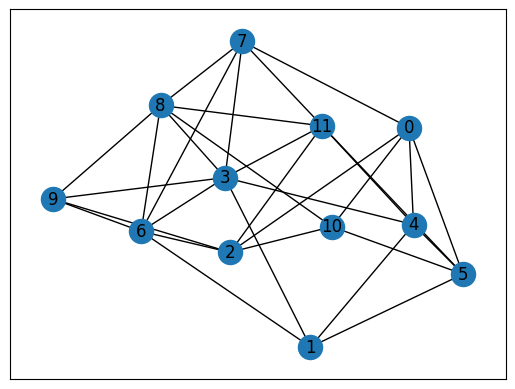

In [47]:
# independent inputs
NumberOfVerticies = 12
RootLambda = 1/3 # ratio of good states to all states
P_L = 0.9
NumberOfShots = 10

# from the input we compute the following
delta = np.sqrt(1 - P_L)
l = int(np.ceil(np.arccosh(1/delta) / np.arccosh(1/np.sqrt(1 - RootLambda*RootLambda)))) // 2

# create random, connected graph
NumberOfComponents = 0

while NumberOfComponents != 1:
    GraphLaplacian = np.zeros((NumberOfVerticies, NumberOfVerticies), dtype=int)
    for i in range(NumberOfVerticies):
        for j in range(i + 1, NumberOfVerticies):
            if np.random.randint(0, 2) == 1:
                GraphLaplacian[i][j] = GraphLaplacian[j][i] = - 1
        GraphLaplacian[i][i] = - np.sum(GraphLaplacian[i])

    NumberOfComponents = NumberOfVerticies - np.linalg.matrix_rank(GraphLaplacian)

createGraph(GraphLaplacian)

NumberOfEdges = np.trace(GraphLaplacian) // 2

y = (4 * NumberOfVerticies + int(np.sqrt(8*NumberOfVerticies + 1) - 1)) // 8 if NumberOfComponents == 1 else (2 * NumberOfVerticies + NumberOfEdges - 1) // 4 # one less then the Erdos-Edwards bound
digits = int(np.ceil(np.log2(NumberOfEdges))) + 1 # + 1 for the sign



# this generates a grid
BetaGrid = 3
GammaGrid = 3
D = 1
p = 1

grid = []
for beta in range(1, BetaGrid):
    for gamma in range(1, GammaGrid):
        grid.append([beta, gamma])

GridPaths = []
for pair in grid:
    GridPaths.append([pair])

# constant paths
for angles in GridPaths:
    for i in range(1, p):
        angles += [angles[-1]]

'''
for i in range(1, p):
    NewGridPaths = []
    for angles in GridPaths:
        for pair in grid:
            d = [(pair[0] - angles[-1][0])%BetaGrid, (pair[1] - angles[-1][1])%GammaGrid]
            if abs(d[0]) + abs(d[1]) <= D:
                NewGridPaths.append(angles + [pair])
    GridPaths = NewGridPaths
'''

### results:

In [48]:
from multiprocessing import Pool

def GQAOA(angles):
    return GroverQAOACircuit(GraphLaplacian, digits, y, delta, l, angles, NumberOfShots)

with Pool() as pool:
    results = list(pool.imap_unordered(GQAOA, GridPaths))

results.sort(key = lambda x: x[1])





s = f"cut threshold\t\t= {y}\nGrover query complexity\t= {l}\nsquare root of lambda\t= {RootLambda}\nP_L\t\t\t= {P_L * 100}%\np\t\t\t= {p}\nBetaGrid\t\t= {BetaGrid}\nGammaGrid\t\t= {GammaGrid}\n\nmaxcut\tM\tconfiguration\t\t\tangle\n\n"
for result in results[-10:]:
    s += f"{result[0]}\t{result[1]}\t{result[3]}\t{result[2]}\n"
s += f"\nthe graph (number of edges = {np.trace(GraphLaplacian) // 2}, maxcut = {MaxCut}, ratio = {results[-1][0] / MaxCut})\n\n"
for row in GraphLaplacian:
    s += f"{row.view()}\n"

print(s)

KeyboardInterrupt: 

In [50]:
MaxCut = 0
maxconf = np.zeros(NumberOfVerticies)
for x in range(1 << (NumberOfVerticies - 1)):
    conf = np.array([(x >> i)&1 for i in range(NumberOfVerticies)])
    cut = np.matmul(conf, np.matmul(GraphLaplacian, np.transpose(conf)))
    if cut > MaxCut:
        MaxCut = cut
        maxconf = conf

print(f"MaxCut\t= {MaxCut}\nmaxconf\t= {maxconf}")

MaxCut	= 23
maxcont	= [0 0 1 1 1 1 0 1 1 0 0 0]
